# Deflection-Profile Verification
This file verifies the Deflection-Profile implementation provided in the file "deflection_profile.py" of the bmcs_beam package.

In [1]:
%matplotlib inline

In [2]:
from bmcs_cross_section.mkappa import MKappa
from bmcs_beam.beam_config.boundary_conditions import BoundaryConditions
from bmcs_beam.bending.deflection_profile import DeflectionProfile
from bmcs_beam.beam_config.beam_design import BeamDesign
from bmcs_cross_section.cs_design.cs_shape import TShape
from os.path import join
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import bmcs_utils.api as bu

In [3]:
def plot(mc):
    fig, ax = plt.subplots(1, 1)
    dp = DeflectionProfile(mc=mc)
    F, w = dp.get_Fw()
    ax.plot(w, F / 1000, c= 'blue', label= 'bmcs_deflection'); ax.legend()
    ax.set_xlabel(r'$w$ [mm]')
    ax.set_ylabel(r'$F$ [kN]')
    plt.show()
    
def plot_fw_ver(mc, ver_data):
    fig, ax = plt.subplots(1,1)
    dp.plot_fw(ax)
    f = ver_data[0]
    w = ver_data[1]
    ax.plot(f, w, c= 'red', label= 'Experiment')
    ax.legend()
    plt.show()

## 1. Checking the model with its default parameters

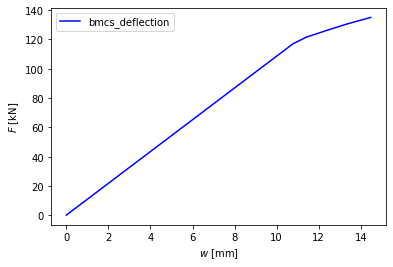

In [4]:
mc = MKappa(low_kappa=-0.000014, high_kappa=0.00001)
plot(mc)

## 2. Verification with experimental results

Verification with experimental results from multiple papers using the summarized parameters in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)

Notation in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) | Notation in this file
----------- | -----------
$E$      | E_ct
$E_c$   | E_cc
$E_s$ | E_j
$\varepsilon_{cr}$ | eps_cr
$\varepsilon_{cu}$ | eps_cu
$\varepsilon_{tu}$ | eps_tu
$\varepsilon_{cy}$ | eps_cy
$\mu$ | mu
$\gamma$  | E_cc/E_ct
$\omega$  | eps_cy/eps_cr
$\lambda_{cu}$  | eps_cu/eps_cr
$\beta_{tu}$  | eps_tu/eps_cr
$\psi$  | eps_sy_j/eps_cr
$n$  | E_j/E_ct
$\alpha$  | z_j/h
$r$  | A_s_c/A_s_t
$\rho_g$ | A_j[0]/A_c, where A_j[0] must be tension steel area

### Verification with Rectangluar cross sections
In the following verifications, the parameters will be taken from the parameters summary in Table 3 in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404)
And the following functions is provided to map the params in the format used in [Yao_Mobasher2019](https://doi.org/10.1002/suco.201900404) to the format of the Deflection model

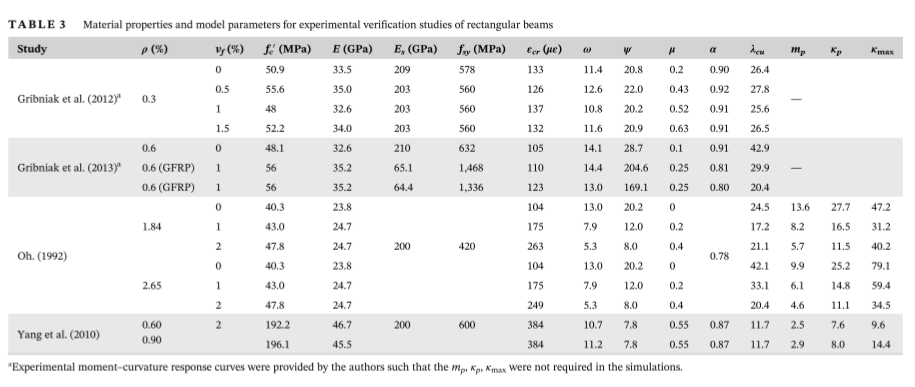

In [5]:
def map_and_assign_params_for_rectangular_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    mc.cross_section_shape.B=b
    mc.cross_section_shape.H=h
    mc.E_cc=E
    mc.E_ct=E # SUPPOSED equal to E_cc!!
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]

#### 1. Verification with Bielak (2019), https://doi.org/10.3390/app9071382, Carbon reinforcement
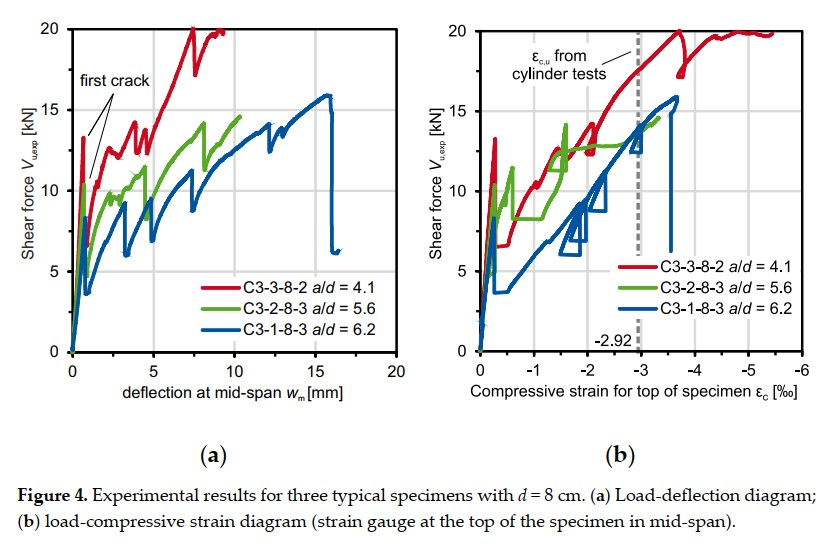

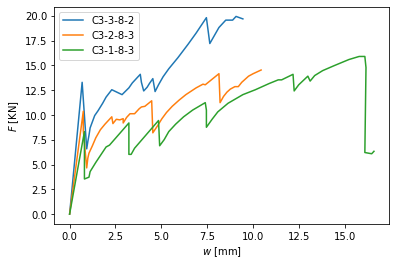

In [6]:
excel_file = join('./verification_data/Bie19','Bielak_2019.xlsx')
data = pd.read_excel(excel_file)

w_= data['C3-3-8-2_w']  ; f_= data['C3-3-8-2_F'] ; ver_data = [w_, f_]; plt.plot(w_,f_, label = 'C3-3-8-2')
w_1= data['C3-2-8-3_w']  ; f_1= data['C3-2-8-3_F'] ; ver_data1 = [w_1, f_1]; plt.plot(w_1,f_1, label = 'C3-2-8-3')
w_2= data['C3-1-8-3_w']  ; f_2= data['C3-1-8-3_F'] ; ver_data2 = [w_2, f_2]; plt.plot(w_2,f_2, label = 'C3-1-8-3')

plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [KN]');

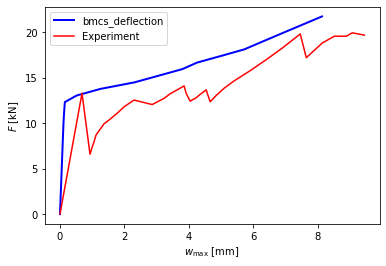

In [7]:
# C3-3-8-2
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0003
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 2 * 320

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 200,
            h = 99,
            rho = 0.00234,
            v_f = 0.0,
            E = 44429 * 0.7,
            E_s = 244835 * 0.20, #Warp:244835, Weft:243828
            f_sy = 3221 , #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616, #eps_sy_j/eps_cr
            mu = 0.0, #σp/σcr
            alpha = 0.77, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data)

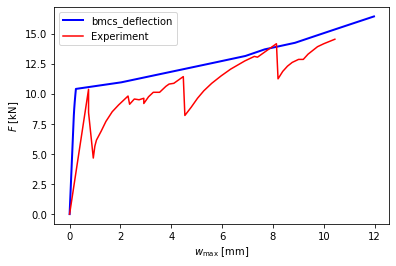

In [8]:
# C3-2-8-3
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0003
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 2 * 400

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 199,
            h = 100,
            rho = 0.00256,
            v_f = 0.0,
            E = 45346 * 0.7,
            E_s = 244835 * 0.2, #Warp:244835, Weft:243828
            f_sy = 3221 , #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616, #eps_sy_j/eps_cr
            mu = 0.0, #σp/σcr
            alpha = 0.71, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data1)

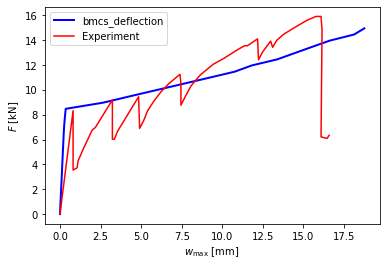

In [9]:
# C3-1-8-3
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.0003
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 2 * 480

map_and_assign_params_for_rectangular_section(dp.mc,
            beta_tu = 2,  #  eps_tu/eps_cr
            b = 201,
            h = 100,
            rho = 0.00233,
            v_f = 0.0,
            E = 44010 * 0.7,
            E_s = 244835 * 0.2, #Warp:244835, Weft:243828
            f_sy = 3221 , #Warp:3221, Weft:3334
            eps_cr = 0.0002616,
            omega = 0.28/0.2616, #eps_cy/eps_cr
            psi = 13.2/0.2616, #eps_sy_j/eps_cr
            mu = 0.0, #σp/σcr
            alpha = 0.77, #z_j/h
            lambda_cu = 2.92/0.2616) #eps_cu/eps_cr

plot_fw_ver(dp.mc, ver_data2)

### Verification with T-sections

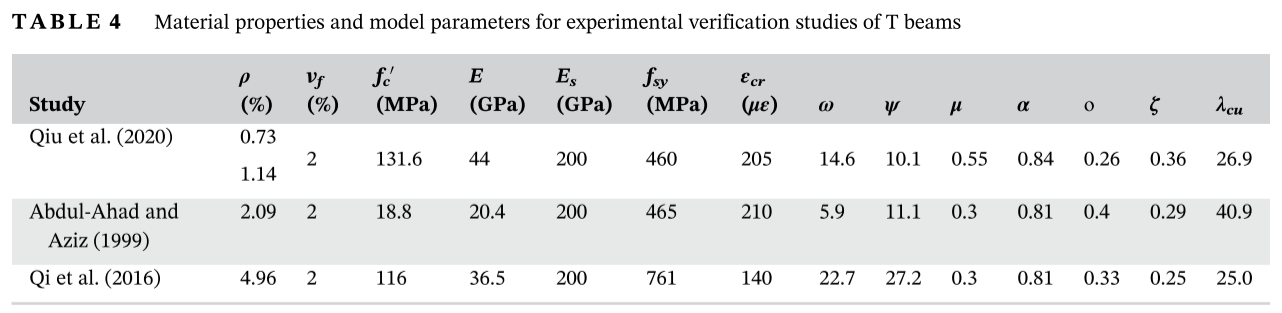

In [10]:
def map_and_assign_params_for_t_section(
        mc, # MKappa instance for which the params should be applied
        b, h, E, E_s, f_sy, eps_cr, rho, beta_tu, v_f, omega, psi, mu, alpha, lambda_cu, o, zeta):
    """This function map the params of the rectangular section from the type of the paper
    to the type of the model and assigns the values"""
    t_shape = TShape(B_f = b, B_w = o*b, H_w = (1-zeta)*h)
    mc.cross_section_shape = t_shape
    
    mc.E_cc=E
    mc.E_ct=E # SUPPOSED equal to E_cc!!
    mc.mu=mu
    mc.eps_cr=eps_cr
    mc.eps_cy=omega * eps_cr
    mc.eps_cu=lambda_cu * eps_cr
    mc.eps_tu=beta_tu * eps_cr
    mc.eps_sy_j=[f_sy / E_s] # or eps_sy_j=psi * eps_cr,
    mc.E_j=[E_s]
    mc.z_j=[h * (1 - alpha)]
    mc.A_j=[rho * b * h]
    

#### 1. Verification with Qi et al. (2016), https://doi.org/10.1002/suco.201500191, Steel reinforcement


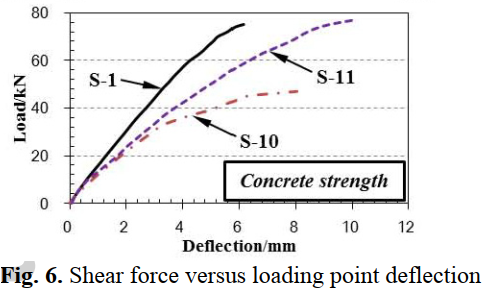

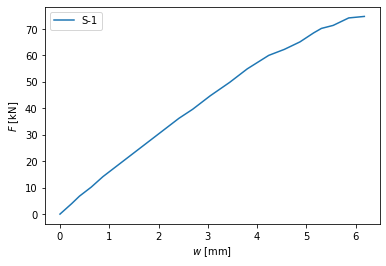

In [11]:
excel_file = join('./verification_data/yao20_yao_mobasher/figure_14','Qi_2016.xlsx') # S_1 line

data = pd.read_excel(excel_file)
w_= data['S_1_exp_w'] ; f_= data['S_1_exp_F'] / 1000; ver_data = [w_, f_]; plt.plot(w_,f_, label = 'S-1')

plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [kN]');

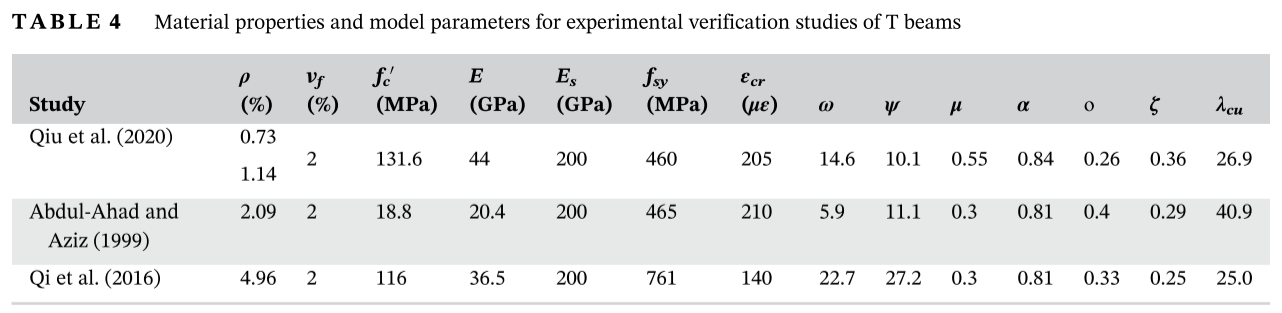

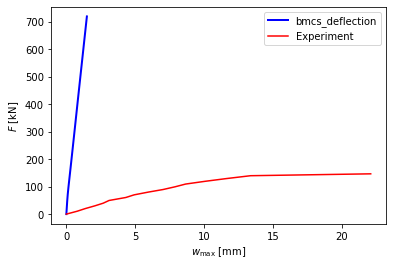

In [37]:
# S-1
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.000015
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[0]

dp.beam_design.L = 1100

map_and_assign_params_for_t_section(dp.mc,
            beta_tu = 15,  # SUPPOSED because it's missing
            b = 120,
            h = 140,
            rho = 0.0496,
            v_f = 0.02,
            E = 36500,
            E_s = 200000 ,
            f_sy = 761,
            eps_cr = 0.000140,
            omega = 22.7,
            psi = 27.2,
            mu = 0.3,
            alpha = 0.81,
            o = 0.33, 
            zeta = 0.25,
            lambda_cu = 25)

plot_fw_ver(mc, ver_data)

#### 2. Verification with Abdul-Ahad and Aziz (1999), https://doi.org/10.1002/suco.201500191, Steel reinforcement


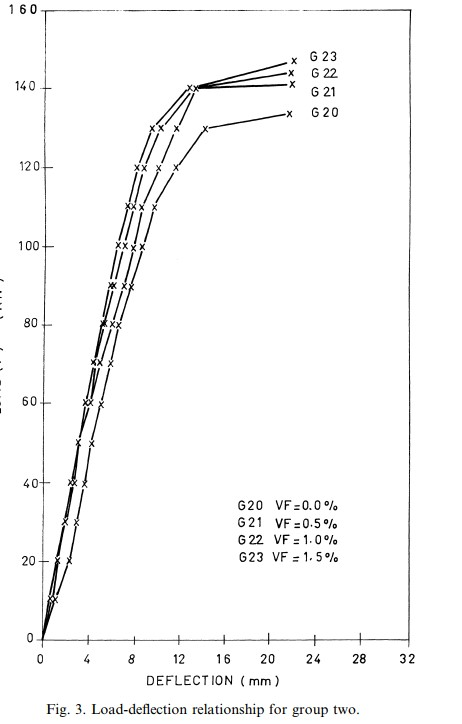

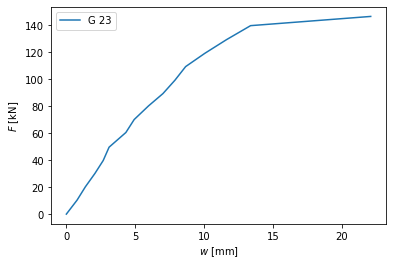

In [13]:
excel_file = join('./verification_data/yao20_yao_mobasher/figure_14', 'abdul_1999.xlsx') # G 23 line
data = pd.read_excel(excel_file)
w_= data['G23_w'] ; f_= data['G23_F'] ; ver_data = [w_, f_]; plt.plot(w_,f_, label = 'G 23')
plt.legend(); plt.xlabel(r'$w$ [mm]'); plt.ylabel(r'$F$ [kN]');

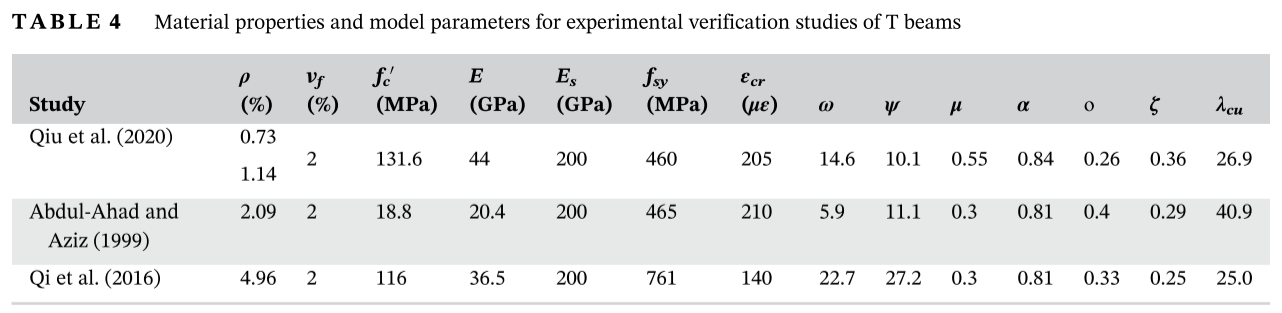

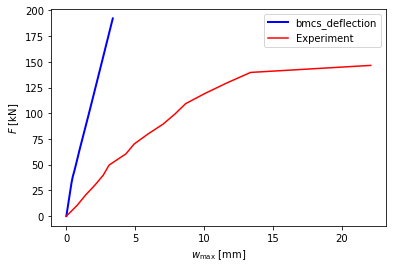

In [41]:
# G 23
mc = MKappa(n_m=100, n_kappa = 100)
dp = DeflectionProfile(mc=mc)
dp.mc.low_kappa = 0
dp.mc.high_kappa = 0.000008
# Select the loading conditions, CONFIG_NAMES[0]: 3pb; CONFIG_NAMES[1]: 4pb
dp.beam_design.beam_conf_name = BoundaryConditions.CONFIG_NAMES[1]

dp.beam_design.L = 2000

map_and_assign_params_for_t_section(dp.mc,
            beta_tu = 15,  # SUPPOSED because it's missing
            b = 250,
            h = 210,
            rho = 0.0209,
            v_f = 0.02,
            E = 20400,
            E_s = 200000,
            f_sy = 465,
            eps_cr = 0.000210,
            omega = 5.9,
            psi = 11.1,
            mu = 0.3,
            alpha = 0.81,
            o = 0.4, 
            zeta = 0.29,
            lambda_cu = 40.9)

plot_fw_ver(mc, ver_data)